# Table of content
- Extract fpkm and perform log2 transformation
- [Generate DE figures (as pdf)](#Generate-DE-figures-(as-pdf))
- [Save plot as png](#Save-plot-as-png)

# Extract fpkm and perform log2 transformation

In [1]:
cd $RNA_HOME/de/ballgown/ref_only/
pwd

/home/ubuntu/workspace/rnaseq/de/ballgown/ref_only


In [ ]:
R
#load libraries
library(ballgown)
library(genefilter)
library(dplyr)
library(devtools)

# set the working directory
setwd("~/workspace/rnaseq/de/ballgown/ref_only")

# Define the conditions being compared for use later
condition = c("UHR", "UHR", "UHR", "HBR", "HBR", "HBR")

# Load the ballgown object from file
load("bg.rda")

# The load command, loads an R object from a file into memory in our R session.
# You can use ls() to view the names of variables that have been loaded
ls()

# Print a summary of the ballgown object
bg #ballgown instance with 4564 transcripts and 6 samples

# Load gene names for lookup later in the tutorial
bg_table = texpr(bg, "all") # extract "all" transcript-level expression measurements (voverage, FPKM) and metadata (transcript ID, gene ID, gene name, etc.) from ballgown objects
bg_gene_names = unique(bg_table[, 9:10])

# Pull the gene and transcript expression data frame from the ballgown object
gene_expression = as.data.frame(gexpr(bg))
transcript_expression = as.data.frame(texpr(bg))

#View expression values for the transcripts of a particular gene symbol of chromosome 22.  e.g. 'TST'
#First determine the transcript_ids in the data.frame that match 'TST', aka. ENSG00000128311, then display only those rows of the data.frame
head(bg_table)
i = bg_table[, "gene_name"] == "TST"
bg_table[i,]
# Save a tab delimited file for both the transcript and gene results
write.table(bg_table[i,], "TST.tsv", sep = "\t", quote = FALSE, row.names = FALSE)
# to load: results_genes <- read.table("TST.tsv", header = TRUE, sep = "\t", stringsAsFactors = FALSE)

# Display the transcript ID for a single row of data
ballgown::transcriptNames(bg)[2763] #or: bg_table[2763, "t_name"]

# Display the gene name for a single row of data
ballgown::geneNames(bg)[2763] #or: bg_table[2763, "gene_name"]

#What if we want to view values for a list of genes of interest all at once?
genes_of_interest = c("TST", "MMP11", "LGALS2", "ISX")
i = bg_table[, "gene_name"] %in% genes_of_interest
bg_table[i,]

# Load the transcript to gene index from the ballgown object
# slotNames(bg) # list all components of bg
# names(indexes(bg))  # shows all available subcomponents
transcript_gene_table = indexes(bg)$t2g #bg@indexes is a list, and one of its components is t2g.
head(transcript_gene_table)

#Each row of data represents a transcript. Many of these transcripts represent the same gene. Determine the numbers of transcripts and unique genes
length(unique(transcript_gene_table[, "t_id"])) #Transcript count: 4564
length(unique(transcript_gene_table[, "g_id"])) #Unique Gene count: 1410

# Extract FPKM values from the 'bg' object
fpkm = texpr(bg, meas = "FPKM")

# View the last several rows of the FPKM table
tail(fpkm)

# Transform the FPKM values by adding 1 and convert to a log2 scale
fpkm = log2(fpkm + 1)
# It is standard practice to add 1 before taking the log2 of expression values like FPKM or TPM, precisely to avoid the issue of log2(0), which is undefined. After add 1, log2(0+1) is still 0 for lowly expressed or non-expressed genes/transcripts.

# View the last several rows of the transformed FPKM table
tail(fpkm)

# Some outputs of the R codes above

#### 1. head(bg_table)

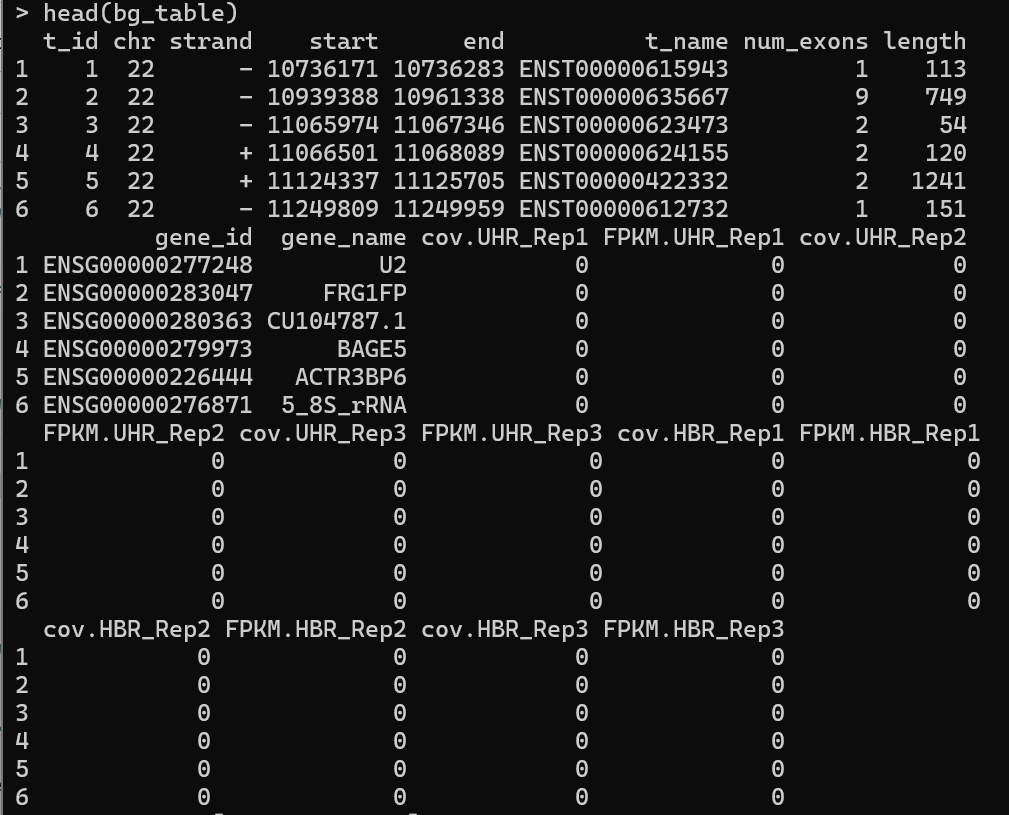

#### 2. bg_table[i,]

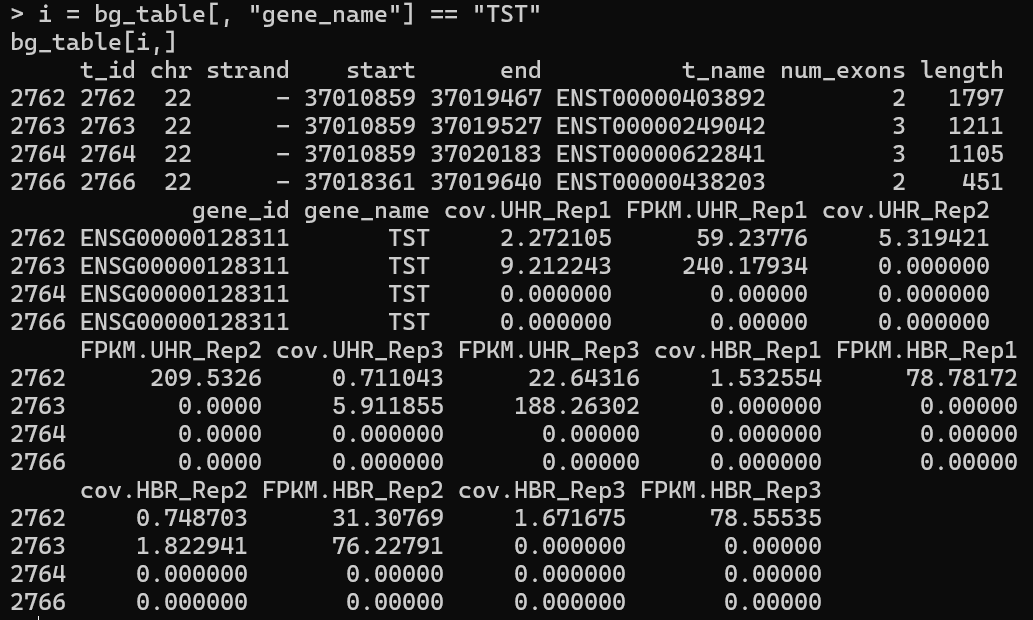

#### 3. slotNames(bg)

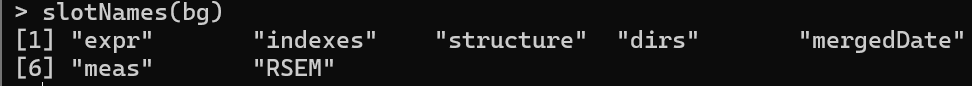

#### 4. names(indexes(bg))

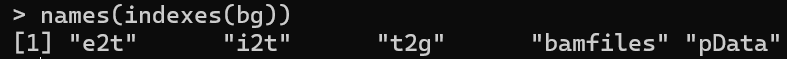

#### 5. head(transcript_gene_table)

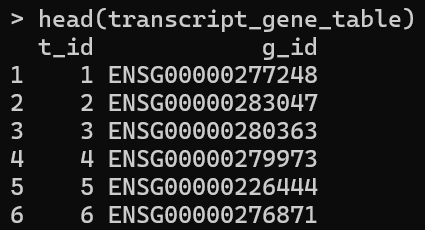

#### 6. log2 transformation of fpkm (notice where fpkm = 0 before and after log2 transformation)

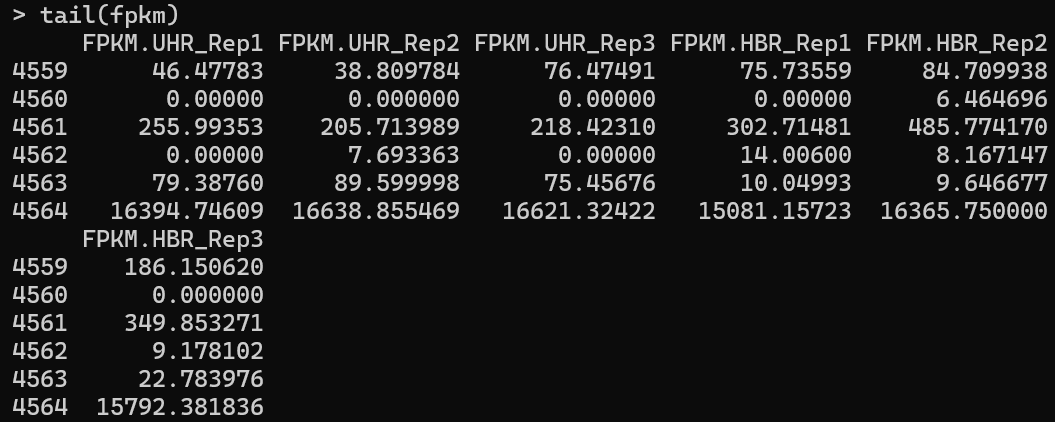
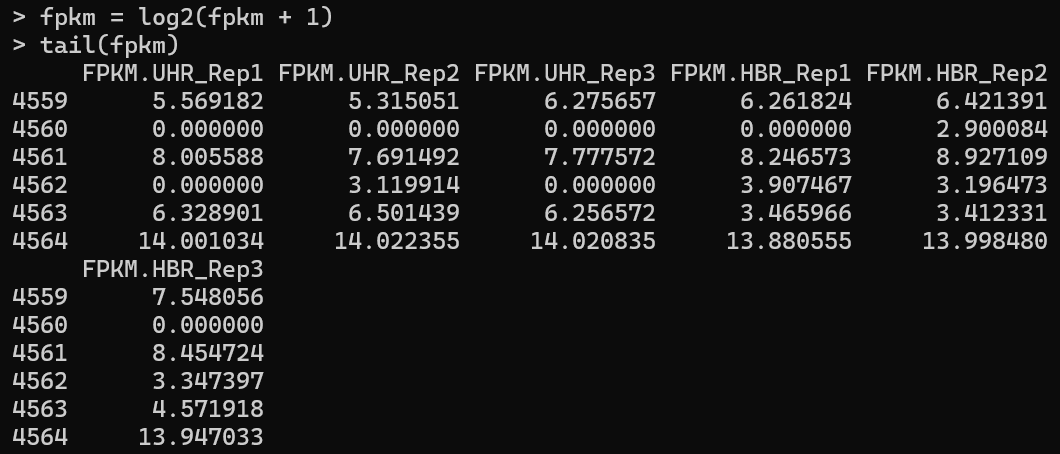

# Generate DE figures (as pdf)
View result at: 
http://YOUR_PUBLIC_IPv4_ADDRESS/rnaseq/de/ballgown/ref_only/*.pdf

In [ ]:
#### Plot #1 - the number of transcripts per gene.
#Many genes will have only 1 transcript, some genes will have several transcripts
#Use the 'table()' command to count the number of times each gene symbol occurs (i.e. the # of transcripts that have each gene symbol)
#Then use the 'hist' command to create a histogram of these counts
#How many genes have 1 transcript?  More than one transcript?  What is the maximum number of transcripts for a single gene?
pdf(file="TranscriptCountDistribution.pdf")
counts=table(transcript_gene_table[, "g_id"])
c_one = length(which(counts == 1)) #number of genes with only 1 transcript
c_more_than_one = length(which(counts > 1)) #number of genes with more than 1 transcript
c_max = max(counts) # the maximum transcript for a single gene
hist(counts, breaks = 50, col = "bisque4", xlab = "Transcripts per gene", main = "Distribution of transcript count per gene")
legend_text = c(paste("Genes with one transcript =", c_one), paste("Genes with more than one transcript =", c_more_than_one), paste("Max transcripts for single gene = ", c_max))
legend("topright", legend_text, lty = NULL)
dev.off()

#### Plot #2 - the distribution of transcript sizes as a histogram
#In this analysis we supplied StringTie with transcript models so the lengths will be those of known transcripts
#However, if we had used a de novo transcript discovery mode, this step would give us some idea of how well transcripts were being assembled
#If we had a low coverage library, or other problems, we might get short "transcripts" that are actually only pieces of real transcripts
pdf(file = "TranscriptLengthDistribution.pdf")
hist(bg_table$length, breaks = 50, xlab = "Transcript length (bp)", main = "Distribution of transcript lengths", col = "steelblue")
dev.off()

#### Plot #3 - distribution of gene expression levels for each sample
# Create boxplots to display summary statistics for the FPKM values for each sample
# set color based on condition which is UHR vs. HBR
# set labels perpendicular to axis (las=2)
# set ylab to indicate that values are log2 transformed
pdf(file = "All_samples_FPKM_boxplots.pdf")
boxplot(fpkm, 
        col = as.numeric(as.factor(condition)) + 1, #start at color 2, skip color 1 because col = 1 is black, col = 2 is red, col = 3 is green
        las = 2,ylab = "log2(FPKM + 1)")
dev.off()

#### Plot 4 - BoxPlot comparing the expression of a single gene for all replicates of both conditions
# set border color for each of the boxplots
# set title (main) to gene : transcript
# set x label to Type
# set ylab to indicate that values are log2 transformed

pdf(file = "TST_ENST00000249042_boxplot.pdf")
transcript = which(ballgown::transcriptNames(bg) == "ENST00000249042")[[1]] #obtain the index of this transcript id. Simpler method: transcript = which(bg_table$t_name == "ENST00000249042")
# which(ballgown::transcriptNames(bg)...) returns an integer vector, possibly of length > 1 (e.g., c(7, 15) if the name appears multiple times).
# [[1]] is used to extract just the first element from this vector as a single value, not as a vector.

boxplot(fpkm[transcript,] ~ condition, 
        border = c(2, 3), 
        main = paste(ballgown::geneNames(bg)[transcript],": ", ballgown::transcriptNames(bg)[transcript]), 
        pch = 19, xlab = "Type", ylab = "log2(FPKM+1)")

# Add the FPKM values for each sample onto the plot
# set plot symbol to solid circle, default is empty circle
points(fpkm[transcript,] ~ jitter(c(2,2,2,1,1,1)), col = c(2,2,2,1,1,1)+1, pch = 16)
dev.off()


#### Plot 5 - Plot of transcript structures observed and expression level for UHR vs HBR with representative replicate

pdf(file = "TST_transcript_structures_expression.pdf")
par(mfrow = c(2, 1))
plotTranscripts(ballgown::geneIDs(bg)[transcript], bg, main = c("TST in HBR_Rep1"), sample = c("HBR_Rep1"), labelTranscripts = TRUE)
plotTranscripts(ballgown::geneIDs(bg)[transcript], bg, main = c("TST in UHR_Rep1"), sample = c("UHR_Rep1"), labelTranscripts = TRUE)
dev.off()

#### Plot 5' with ylab is t_name instead of their indexes aka t_id
# Extract t_names in the same order as plotted
t_names_ordered <- bg_table[bg_table$gene_id == "ENSG00000128311", "t_name"]

pdf(file = "TST_transcript_structures_expression_t-name.pdf") #default: width = 7 in, height = 7 in
par(mfrow = c(2, 1), oma = c(0, 7, 0, 0)) #oma = c(bottom, left, top, right), add extra 7 lines in to outer left margin
plotTranscripts(ballgown::geneIDs(bg)[transcript], bg, main = c("TST in HBR_Rep1"), sample = c("HBR_Rep1"), labelTranscripts = FALSE)
axis(2, at = 1:length(t_names_ordered), labels = t_names_ordered, las = 2, cex.axis = 0.8) # Replace Y-axis tick labels with transcript names

plotTranscripts(ballgown::geneIDs(bg)[transcript], bg, main = c("TST in UHR_Rep1"), sample = c("UHR_Rep1"), labelTranscripts = FALSE)
axis(2, at = 1:length(t_names_ordered), labels = t_names_ordered, las = 2, cex.axis = 0.8) #cex.axis make ylab smaller

dev.off()

# to remove a file within R: file.remove("TST_transcript_structures_expression_t-name.pdf")

#### Plot 5'': plot all TST transcript expression across all HBR replicates

pdf(file = "TST_transcript_structures_expression_allHBRrep.pdf")
par(mfrow = c(3, 1), oma = c(0, 7, 0, 0))

samples <- c("HBR_Rep1", "HBR_Rep2", "HBR_Rep3")

for (sample in samples) {
  plotTranscripts(ballgown::geneIDs(bg)[transcript], bg,
                  main = paste("TST in", sample),
                  sample = sample,
                  labelTranscripts = FALSE)
  
  axis(2,
       at = 1:length(t_names_ordered),
       labels = t_names_ordered,
       las = 2,
       cex.axis = 0.8)
}

dev.off()

#### Plot 5''': plot all TST transcript expression across all UHR replicates
pdf(file = "TST_transcript_structures_expression_allUHRrep.pdf")
par(mfrow = c(3, 1), oma = c(0, 7, 0, 0))
samples <- c("UHR_Rep1", "UHR_Rep2", "UHR_Rep3")
for (sample in samples) {
  plotTranscripts(ballgown::geneIDs(bg)[transcript], bg,
                  main = paste("TST in", sample),
                  sample = sample,
                  labelTranscripts = FALSE)
  
  axis(2,
       at = 1:length(t_names_ordered),
       labels = t_names_ordered,
       las = 2,
       cex.axis = 0.8)
}
dev.off()

# Exit the R session
quit(save = "no")

# Some output of the above R codes

#### 1. Related to plot 1

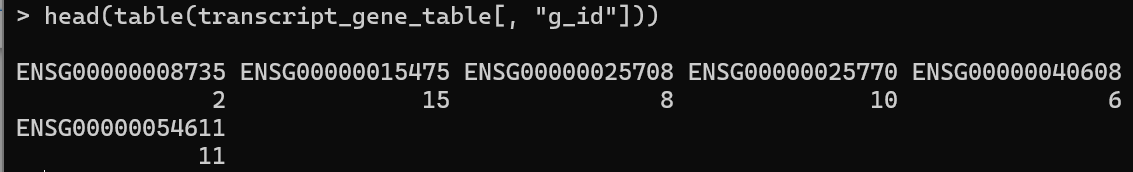

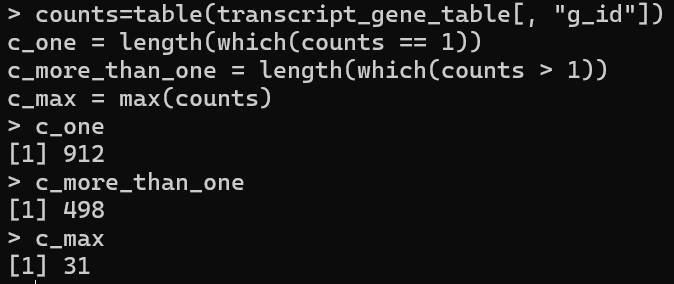

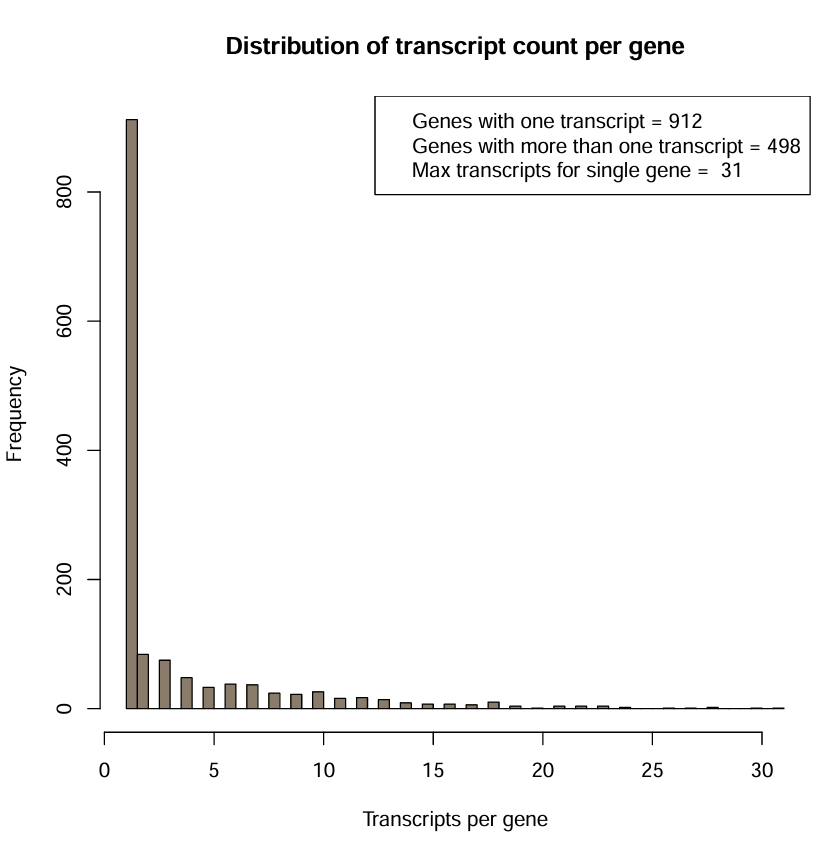

#### 2. Related to plot 2

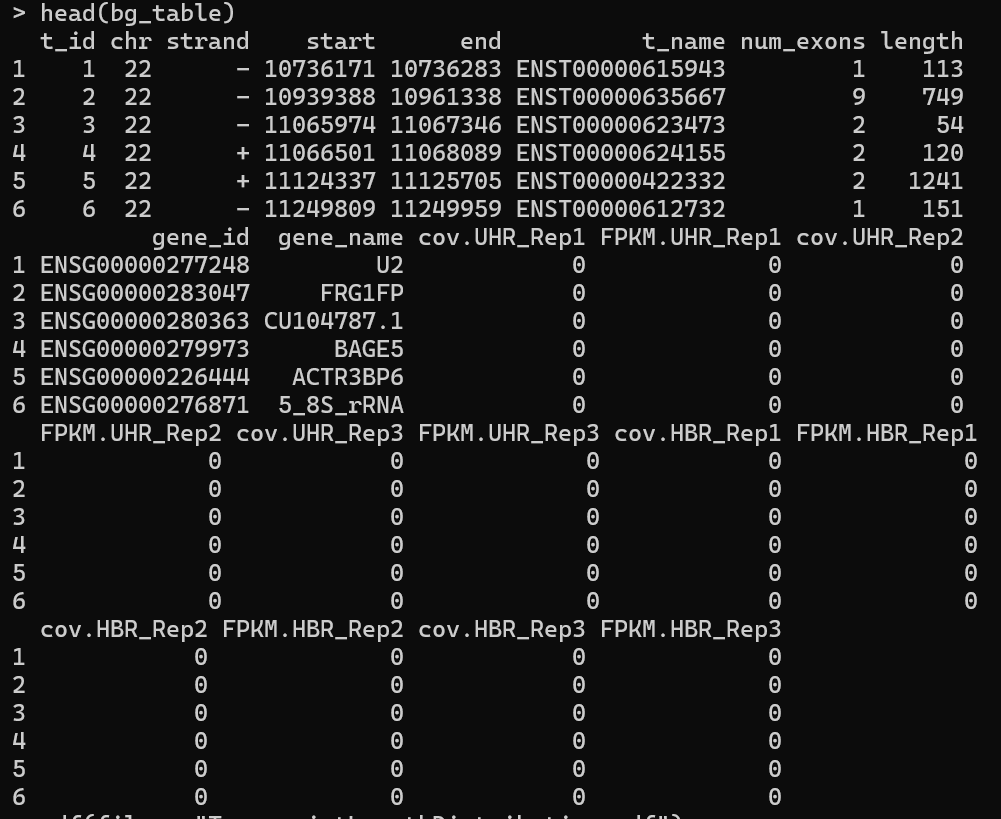

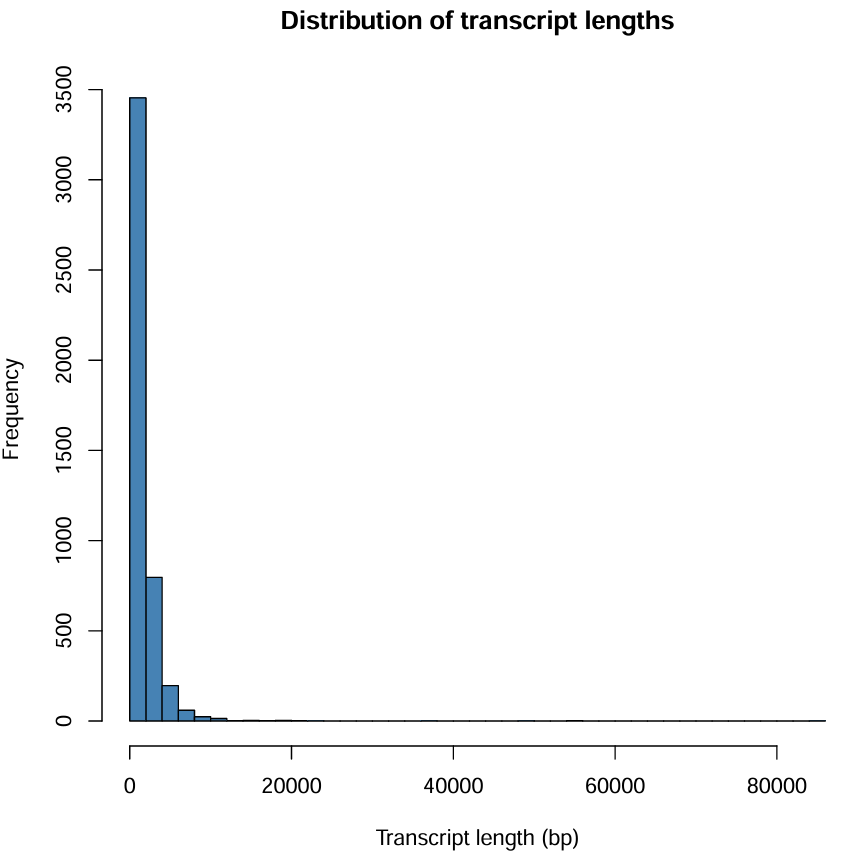

#### 3. Plot 3

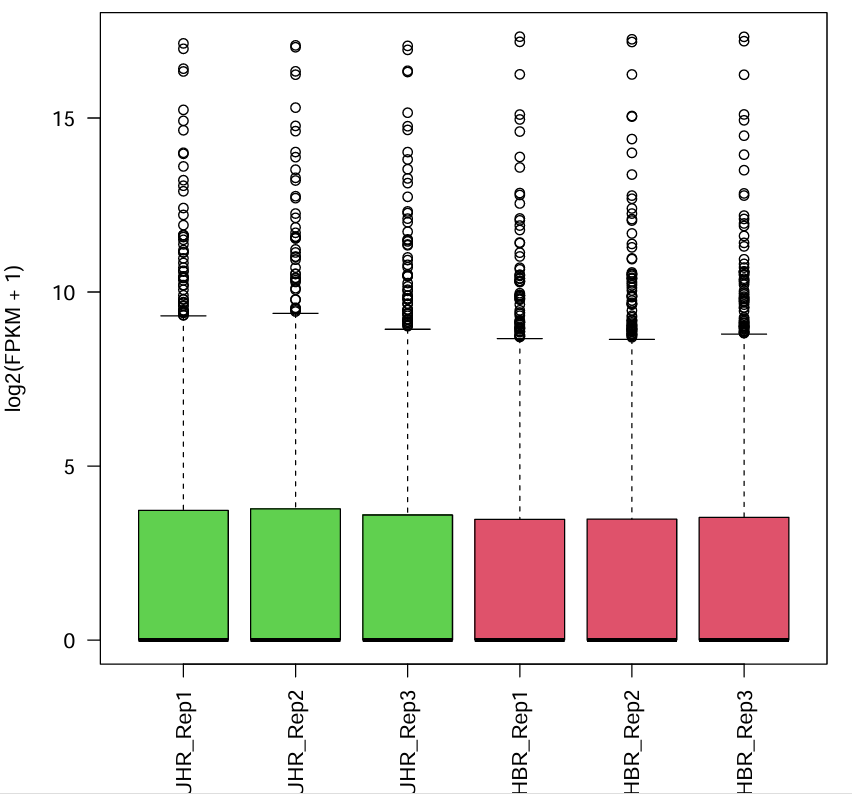

#### 4. Plot 4

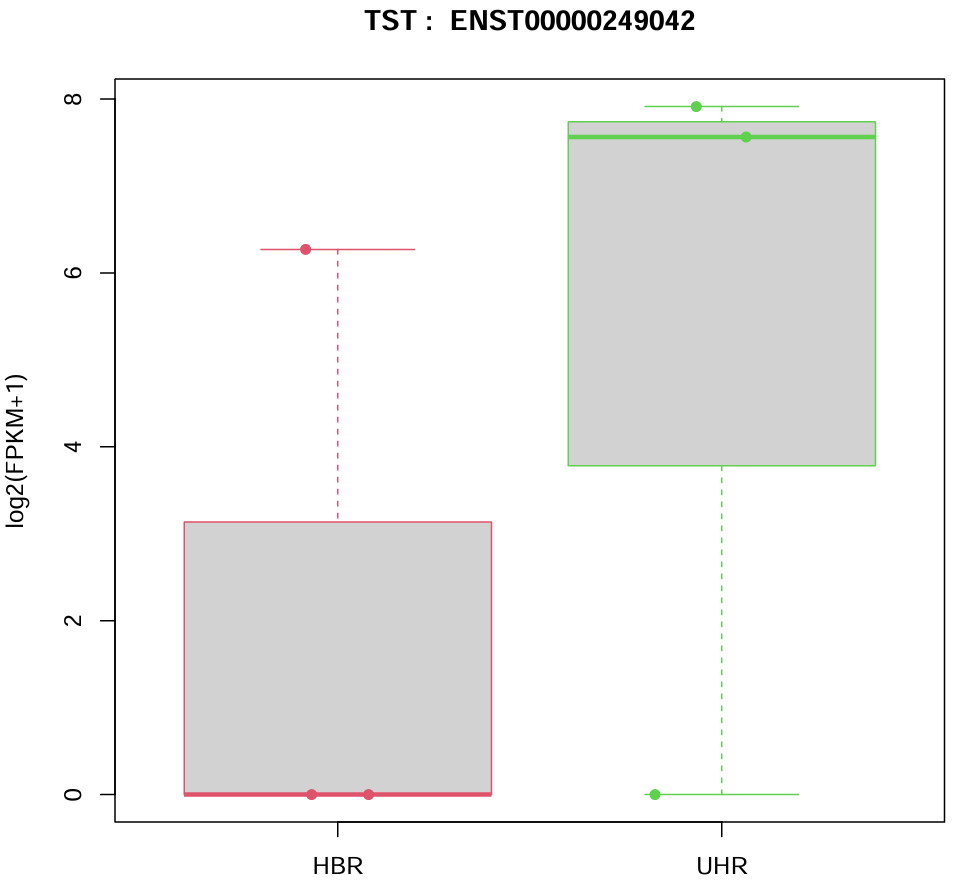

#### 5. Plot 5

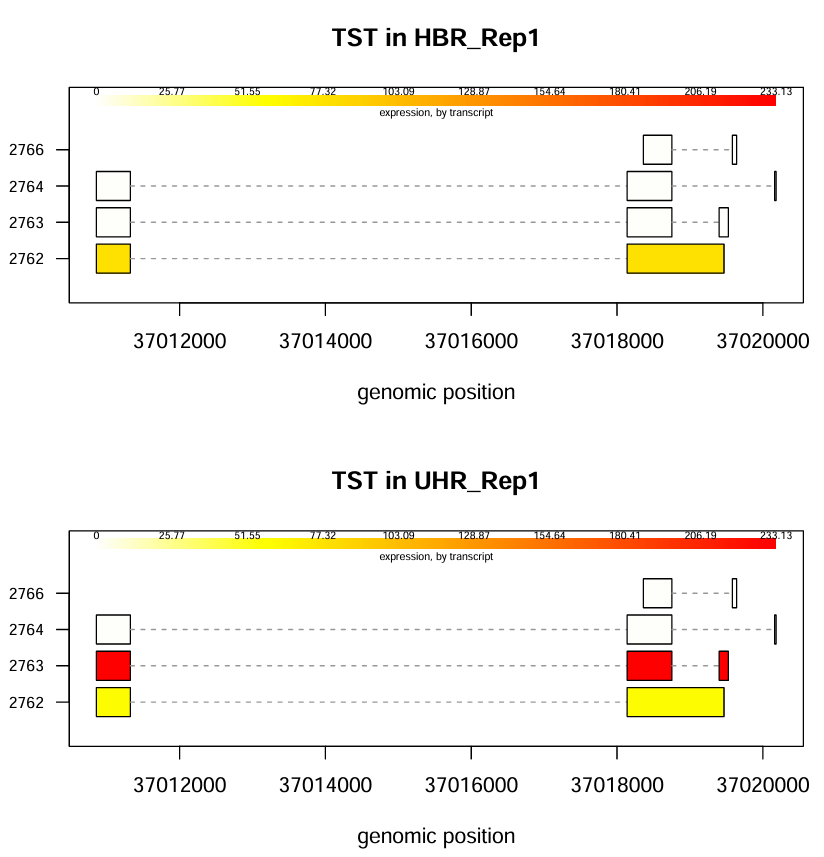

#### 6. Plot 5'

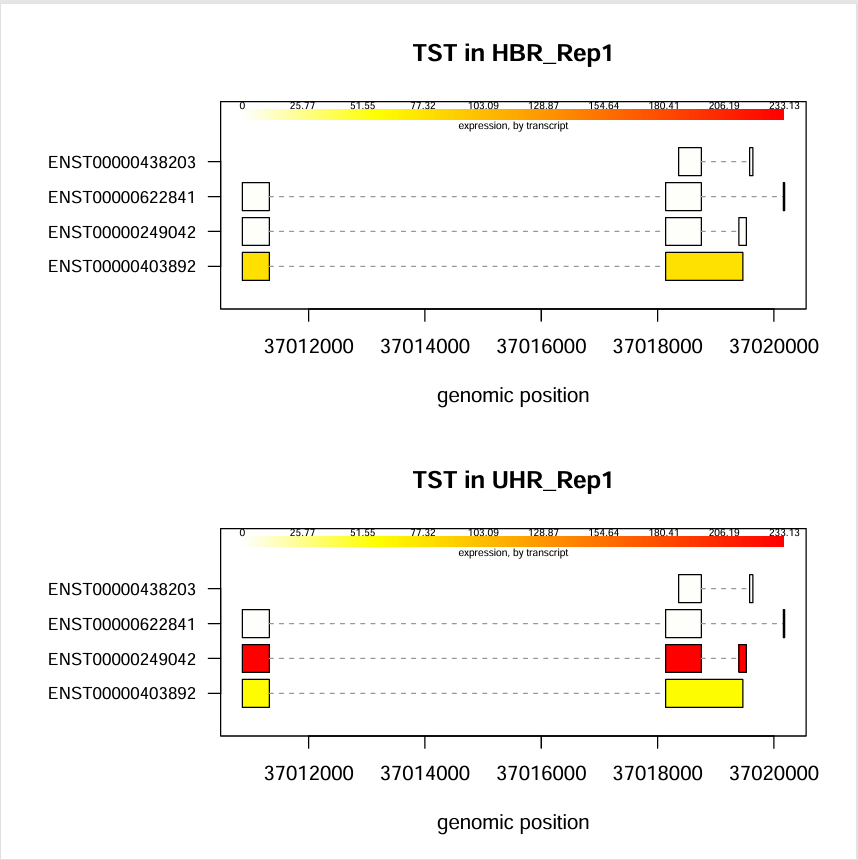

**Syntax: axis(side, at, labels, ...)**
- side = 2 → y-axis (1 = bottom, 2 = left/y-axis, 3 = top, 4 = right)
- at → positions on the axis where tick marks (and optionally labels) are placed
    - at = 1:4 means you're putting tick marks at positions 1, 2, 3, and 4 along the y-axis.
- labels → the actual text to put at each tick mark
- las = 2 → makes labels perpendicular to the axis (i.e., vertical text for y-axis)

#### 7. Plot 5''

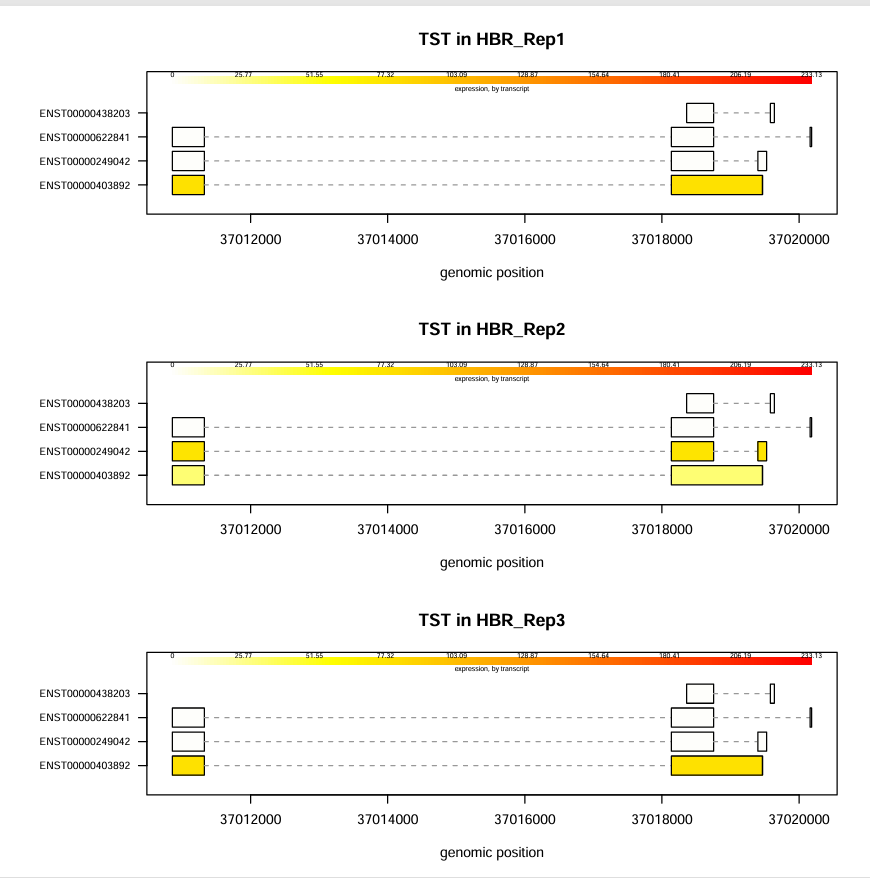

#### 8. Plot 5'''

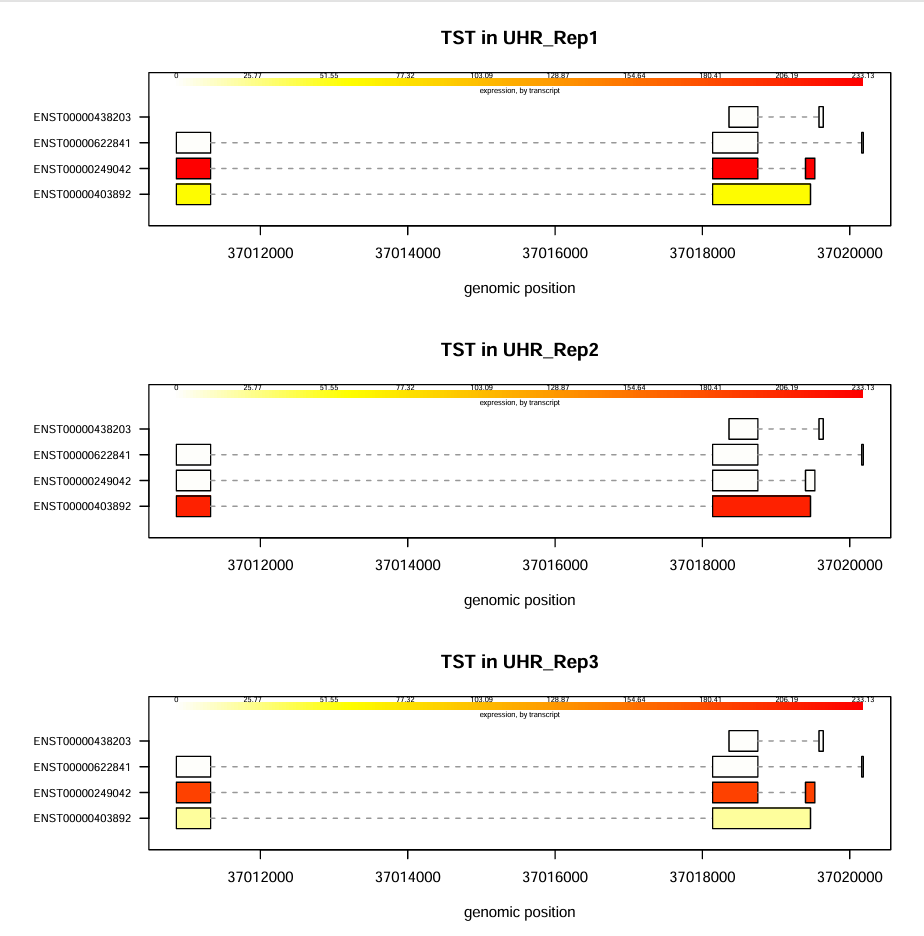

#### [Link to more info about plotTranscripts](https://www.rdocumentation.org/packages/ballgown/versions/2.4.2/topics/plotTranscripts)
The plotTranscripts() function uses the FPKM.* columns in **ballgown::expr(bg)[["trans"]]** aka **bg_table** (bg_table = texpr(bg, "all")). You can compare the value of FPKM.UHR_Rep1 (240.17934) and FPKM.HBR_Rep1 (0.00000) at the index of 2763 in bg_table to the value in the plot.

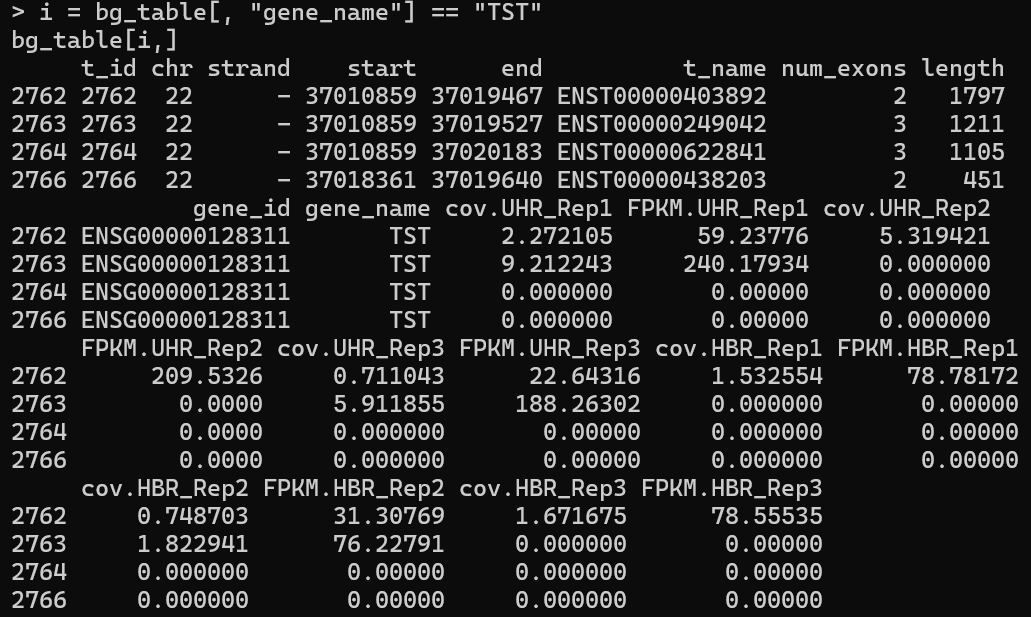


# Save plot as png
Need to finetune image size and font size

In [ ]:
# Plot 1
png(file="TranscriptCountDistribution.png", , width = 800, height = 800, res = 300)
counts=table(transcript_gene_table[, "g_id"])
c_one = length(which(counts == 1))
c_more_than_one = length(which(counts > 1))
c_max = max(counts)
hist(counts, breaks = 50, col = "bisque4", xlab = "Transcripts per gene", main = "Distribution of transcript count per gene")
legend_text = c(paste("Genes with one transcript =", c_one), paste("Genes with more than one transcript =", c_more_than_one), paste("Max transcripts for single gene = ", c_max))
legend("topright", legend_text, lty = NULL)
dev.off()

# Plot 2
png(file = "TranscriptLengthDistribution.png", width = 800, height = 800, res = 300)
hist(bg_table$length, breaks = 50,
     xlab = "Transcript length (bp)",
     main = "Distribution of transcript lengths",
     col = "steelblue")
dev.off()

# Plot 3
png(file = "All_samples_FPKM_boxplots.png", width = 800, height = 800, res = 300)
boxplot(fpkm, col = as.numeric(as.factor(condition)) + 1,las = 2,ylab = "log2(FPKM + 1)")
dev.off()

# Plot 4
png(file = "TST_ENST00000249042_boxplot.png", width = 800, height = 800, res = 300)
transcript = which(ballgown::transcriptNames(bg) == "ENST00000249042")[[1]]
boxplot(fpkm[transcript,] ~ condition, border = c(2, 3), main = paste(ballgown::geneNames(bg)[transcript],": ", ballgown::transcriptNames(bg)[transcript]), pch = 19, xlab = "Type", ylab = "log2(FPKM+1)")
points(fpkm[transcript,] ~ jitter(c(2,2,2,1,1,1)), col = c(2,2,2,1,1,1)+1, pch = 16)
dev.off()

# Plot 5
png(file = "TST_transcript_structures_expression.png", width = 800, height = 800, res = 300)
par(mfrow = c(2, 1))
plotTranscripts(ballgown::geneIDs(bg)[transcript], bg, main = c("TST in HBR"), sample = c("HBR_Rep1"), labelTranscripts = TRUE)
plotTranscripts(ballgown::geneIDs(bg)[transcript], bg, main = c("TST in UHR"), sample = c("UHR_Rep1"), labelTranscripts = TRUE)
dev.off()